## Reading from the file

In [1]:
import re
namesDict ={}
paragraphNames = {}
names = ["Natasha", "Pierre", "Denisov", "Nicholas", "Countess Mary", "Kutuzov", "Bolkonski","Napoleon", "Prince Andrew", "Dolokhov", "Anna Pavlovna", "Helene", "Princess Mary","Prince Vasili", "Bezukhov", "Boris", "Sonya", "Rostovs", "Anatole"]
filepath = 'WarAndPeace_Altered.txt'
with open(filepath) as fp:
    line = fp.readline()
    paragraph = 1
    cntNat=0;
    for name in names:
        namesDict[name]=[]
    while line:
        namesFound = []
        if (len(line)>2):
            for name in names:
                index = line.find(name)
                if index>=0:
                    namesFound.append(name)
                    namesDict[name].append(paragraph)
            if (len(namesFound)>1):
                paragraphNames[paragraph]=namesFound
            paragraph += 1
        line=fp.readline()

## Creating Nodes and Relationships

In [2]:
from neo4j import GraphDatabase, basic_auth

uri = "bolt://127.0.0.1:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "JobEvaluation"))

#Creating person Nodes
for people in namesDict:
    cypher_query = "MERGE (m:PERSON {Name:$people})"

    with driver.session() as session:
        results = session.run(cypher_query, parameters = {'people':people})
        
# Creating Paragraph Nodes
for people in namesDict:
    for p in namesDict[people]:
        cypher_query = "MERGE (m:PARAGRAPH {lineNumber:$p})"

    with driver.session() as session:
        results = session.run(cypher_query, parameters = {'p':p})

#Creating Person and Paragraph Nodes and the Relationship CONTAINS
for people in namesDict:
    for p in namesDict[people]:
        cypher_query = '''MERGE (m:PERSON {Name:$people})
                          MERGE (x:PARAGRAPH {lineNumber:$p})
                          MERGE (x)-[:CONTAINS]->(m)
                        '''
        with driver.session() as session:
            results = session.run(cypher_query, parameters = {'people':people,'p':p})
driver.close()

## Running Cypher Queries on Database

### CO_MENTIONED_WITH Relationship

In [3]:
from neo4j import GraphDatabase, basic_auth

uri = "bolt://127.0.0.1:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "Test"))

cypher_query = '''MATCH (p1:PERSON) -[]-(p:PARAGRAPH)-[]- (p2:PERSON) 
                  WITH p1,p2, count (p.lineNumber) as cnt
                  WHERE cnt > 0
                  MERGE(p1)-[number:CO_MENTIONED_WITH{number:cnt}]->(p2)
               '''
with driver.session() as session:
            results = session.run(cypher_query)

### STRONGEST Relationship

In [4]:
from neo4j import GraphDatabase, basic_auth

uri = "bolt://127.0.0.1:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "Test"))

query = '''
        MATCH (p1:PERSON) -[r:CO_MENTIONED_WITH]-> (p2:PERSON) 
        WITH p1,max(r.number) as MaxValue 
        MATCH (p1:PERSON) -[r:CO_MENTIONED_WITH]-> (p3:PERSON)
        WHERE r.number = MaxValue
        WITH p1,p3,MaxValue
        MERGE(p1)-[:STRONGEST{number:MaxValue}]->(p3)
       '''

with driver.session() as session:
    results = session.run(query)
driver.close()

## Constructing Graphs

### Cumulative Mentions for a given character

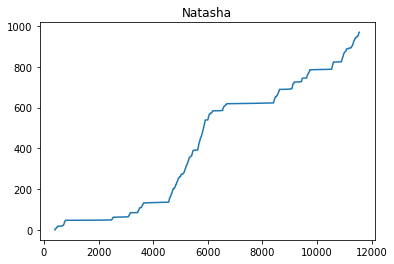

In [5]:
from neo4j import GraphDatabase
import matplotlib.pyplot as plt

def graph_mentions(name):

    uri = "bolt://127.0.0.1:7687"
    driver = GraphDatabase.driver(uri, auth=("neo4j", "Test"))

    cypher_query = '''
                    MATCH (p1{Name:$name}) -[]-(p:PARAGRAPH)
                    RETURN p.lineNumber as Paragraph ORDER BY Paragraph ASC
                   '''
    count =0
    mentioned =[]
    paragraph =[]
    with driver.session() as session:
        results = session.run(cypher_query, parameters ={'name':name})
        for record in results:
            count += 1
            mentioned.append(count)
            paragraph.append(record['Paragraph'])

    return (name,mentioned,paragraph)
    
#Plotting Graph
plt.plot(graph_mentions('Natasha')[2],graph_mentions('Natasha')[1]) 
plt.title(graph_mentions('Natasha')[0]) 
plt.show() 

### Cumulative Mentions for two give characters

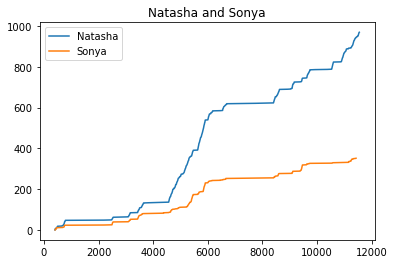

In [6]:
name1 ='Natasha'
name2='Sonya'
Name1Info=graph_mentions(name1)
Name2Info=graph_mentions(name2)

#First character plot
plt.plot(Name1Info[2],Name1Info[1],label=name1) 
#Second character plot
plt.plot(Name2Info[2],Name2Info[1],label=name2) 

plt.title(name1 + ' and '+ name2) 
  
# Show plot legend
plt.legend() 
# Show the plot 
plt.show() 

### Histogram of mentions for a given character

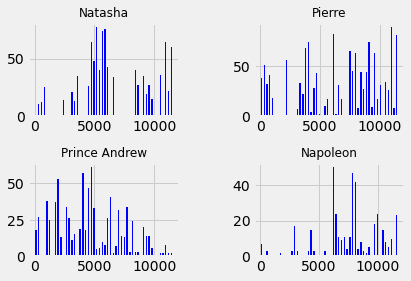

In [8]:
NatashaInfo = graph_mentions('Natasha')
PierreInfo = graph_mentions('Pierre')
PAInfo = graph_mentions('Prince Andrew')
NapoleonInfo = graph_mentions('Napoleon')

bins = 50  

# setting a style to use 
plt.style.use('fivethirtyeight') 
  
# create a figure 
fig = plt.figure() 
  
# define subplots and their positions in figure 
plt1 = fig.add_subplot(221) 
plt2 = fig.add_subplot(222) 
plt3 = fig.add_subplot(223) 
plt4 = fig.add_subplot(224) 
  
# plotting points on each subplot 
range = (0,NatashaInfo[2][-1]) 
plt1.hist(NatashaInfo[2], bins, range, color = 'blue', histtype = 'bar', rwidth = 0.5)
plt1.set_title(NatashaInfo[0], fontsize =12) 
  
range = (0,PierreInfo[2][-1]) 
plt2.hist(PierreInfo[2], bins, range, color = 'blue', histtype = 'bar', rwidth = 0.5)
plt2.set_title(PierreInfo[0], fontsize =12) 
  
range = (0,PAInfo[2][-1]) 
plt3.hist(PAInfo[2], bins, range, color = 'blue', histtype = 'bar', rwidth = 0.5)
plt3.set_title(PAInfo[0], fontsize =12) 
  
range = (0,NapoleonInfo[2][-1]) 
plt4.hist(NapoleonInfo[2], bins, range, color = 'blue', histtype = 'bar', rwidth = 0.5)
plt4.set_title(NapoleonInfo[0], fontsize =12) 
  
# adjusting space between subplots 
fig.subplots_adjust(hspace=0.5,wspace=0.5) 
  
plt.show()

## Graph Algorithms

### PageRank Algorithm

In [13]:


from neo4j import GraphDatabase, basic_auth

uri = "bolt://127.0.0.1:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "Test"))

query = '''CALL gds.graph.create(
  'pageRankGraph',
  'PERSON',
  'STRONGEST',
  {
    relationshipProperties: 'number'
  })
  '''
with driver.session() as session:
    results = session.run(query)

query = ''' CALL gds.pageRank.stream('pageRankGraph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).Name AS name, score
ORDER BY name ASC
'''
score=[]
names=[]
with driver.session() as session:
    results = session.run(query)
    for record in results:
        print(record['name'] +", "+str(record['score']))
        names.append(record['name'])
        score.append(record['score'])

Anatole, 0.27750000506639483
Anna Pavlovna, 0.15000000000000002
Bezukhov, 0.15000000000000002
Bolkonski, 0.15000000000000002
Boris, 0.15000000000000002
Countess Mary, 0.15000000000000002
Denisov, 0.15000000000000002
Dolokhov, 0.15000000000000002
Helene, 0.15000000000000002
Kutuzov, 0.27750000506639483
Napoleon, 0.15000000000000002
Natasha, 7.454265440814196
Nicholas, 0.27750000506639483
Pierre, 1.3322437219321728
Prince Andrew, 0.5133750081062317
Prince Vasili, 0.15000000000000002
Princess Mary, 0.15000000000000002
Rostovs, 0.15000000000000002
Sonya, 6.441649091243743


### Page Rank Pie Chart

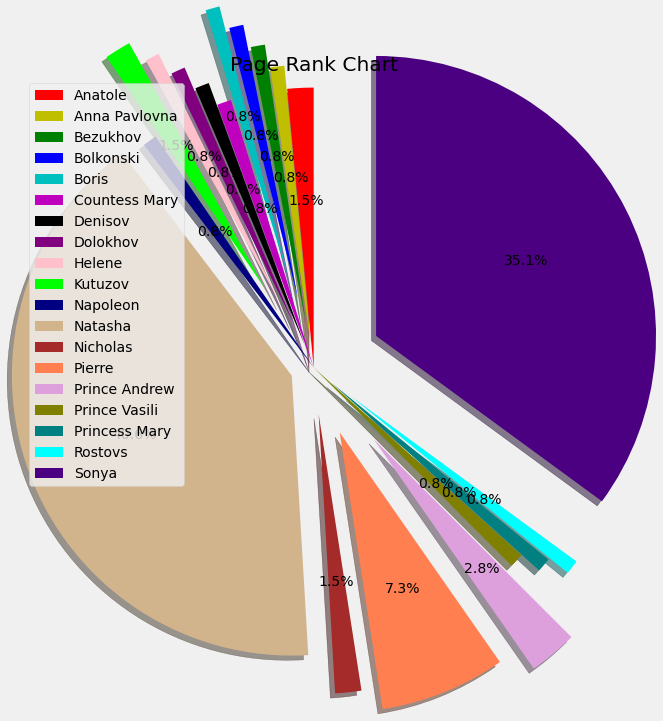

In [14]:
#Resize plot area
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
# color for each label 
colors = ['r', 'y', 'g', 'b','c','m','k','purple','pink','lime','navy','tan','brown','coral','plum','olive','teal','aqua','indigo'] 

# plotting the pie chart 
plt.pie(score,colors=colors,  
        startangle=90, shadow = True, explode = (0, 0.1, 0.2, 0.3,0.4,0,0.1,0.2,0.3,0.4,0,0.1,0.2,0.3,0.4,0,0.1,0.2,0.3), 
        radius = 1.2, autopct = '%1.1f%%') 
# plotting legend 
plt.legend( labels =names)
plt.title('Page Rank Chart')
  
plt.show()

### Betweenness Centrality Algorithm

In [15]:
from neo4j import GraphDatabase, basic_auth

uri = "bolt://127.0.0.1:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "Test"))

query = ''' CALL gds.graph.create('centralityGraph', 'PERSON', 'STRONGEST')'''

with driver.session() as session:
    results = session.run(query)

query = ''' CALL gds.betweenness.stream('centralityGraph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).Name AS name, score
ORDER BY name ASC
'''
score=[]
names=[]
with driver.session() as session:
    results = session.run(query)
    for record in results:
        print(record['name'] +", "+str(record['score']))
        names.append(record['name'])
        score.append(record['score'])


Anatole, 3.0
Anna Pavlovna, 0.0
Bezukhov, 0.0
Bolkonski, 0.0
Boris, 0.0
Countess Mary, 0.0
Denisov, 0.0
Dolokhov, 0.0
Helene, 0.0
Kutuzov, 4.0
Napoleon, 0.0
Natasha, 17.0
Nicholas, 2.0
Pierre, 20.0
Prince Andrew, 9.0
Prince Vasili, 0.0
Princess Mary, 0.0
Rostovs, 0.0
Sonya, 0.0


### Betweenness Centrality Graph

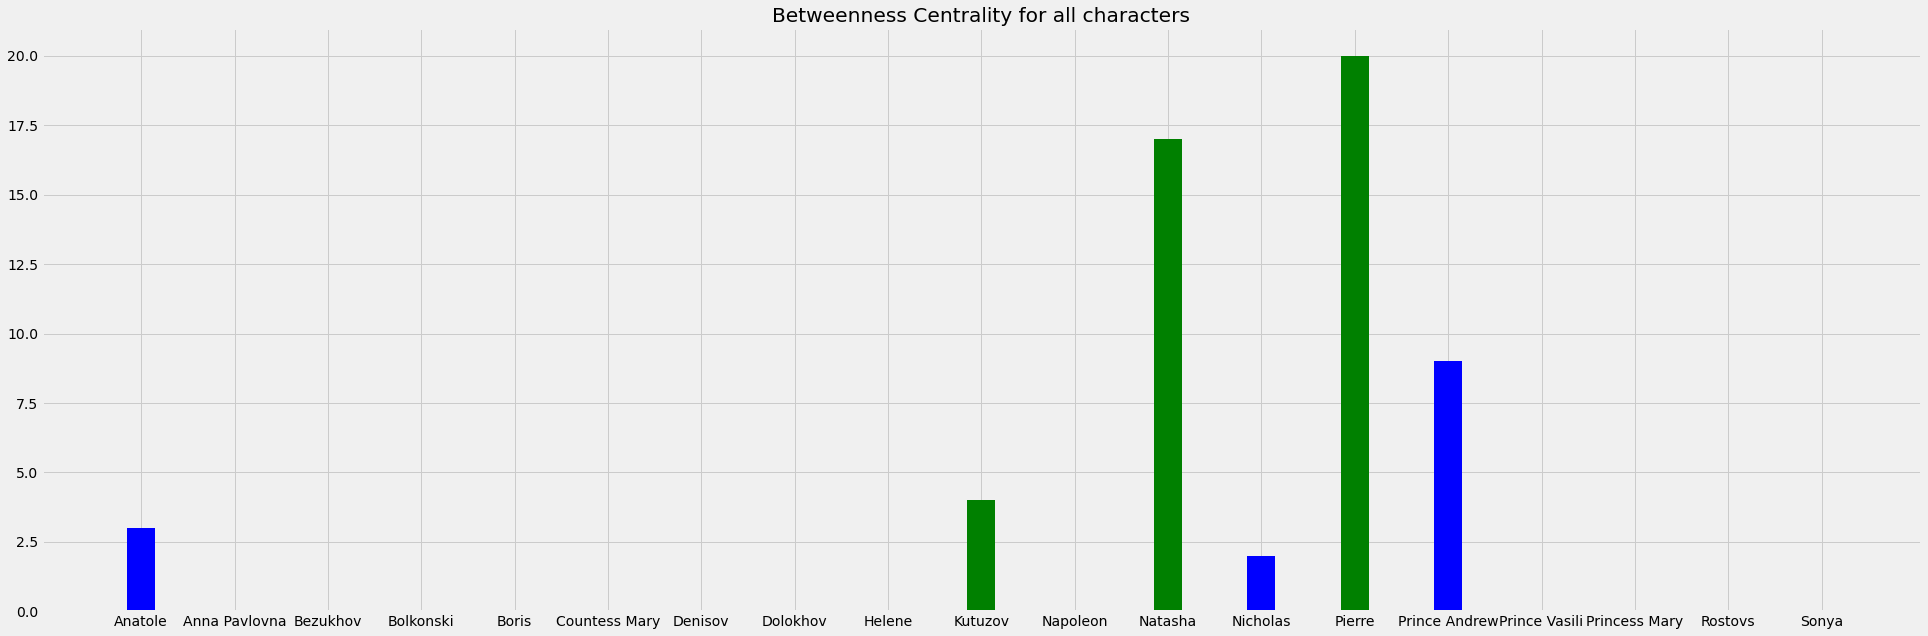

In [16]:
# x-coordinates of left sides of bars  
left = [1, 2, 3, 4, 5,6, 7, 8,9,10,11,12,13,14,15,16,17,18,19] 
  
# plotting a line plot after changing it's width and height
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title('Betweenness Centrality for all characters')

plt.bar(left, score,tick_label= names, width = 0.3, color = ['Blue', 'green']) 
plt.show() 

### Label Propagation Algorithm

In [17]:


from neo4j import GraphDatabase, basic_auth

uri = "bolt://127.0.0.1:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "Test"))

query = '''CALL gds.graph.create(
    'labelPropagationGraph',
    'PERSON',
    'CO_MENTIONED_WITH',
    {
        relationshipProperties: 'number'
    }
)

  '''
with driver.session() as session:
    results = session.run(query)

query = ''' CALL gds.labelPropagation.stream('labelPropagationGraph')
YIELD nodeId, communityId AS Community
RETURN gds.util.asNode(nodeId).Name AS Name, Community
ORDER BY Community, Name
'''
score=[]
names=[]
with driver.session() as session:
    results = session.run(query)
    for record in results:
        print(record['Name']+ ' ' + str(record['Community']) )


Anatole 970
Anna Pavlovna 970
Bezukhov 970
Bolkonski 970
Boris 970
Countess Mary 970
Denisov 970
Dolokhov 970
Helene 970
Kutuzov 970
Napoleon 970
Natasha 970
Nicholas 970
Pierre 970
Prince Andrew 970
Prince Vasili 970
Princess Mary 970
Rostovs 970
Sonya 970
